### Name: Riya Shyam Huddar
### Roll number: MDS202431
### Applied Machine Learning - Assignment 1

### SMS Spam Classification - Model Training

This notebook trains and evaluates machine learning models for SMS spam classification.

Steps:
1. Load prepared train, validation, and test datasets
2. Train baseline models
3. Evaluate models on train and validation data
4. Tune hyperparameters 
5. Evaluate benchmark models on test data and select the best model


In [158]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay



### 1. Load Train, Validation, and Test Sets

We load the preprocessed data splits (train, validation, and test) that include:
- `cleaned_text`: the cleaned SMS message
- `label_encoded`: 0 for ham, 1 for spam

This ensures that we use the same data pipeline for training and evaluation.


In [160]:
DATA_DIR = r"D:\CMI\AppliedML\Assignment 1\data\processed"

train_df = pd.read_csv(f"{DATA_DIR}\\train.csv")
val_df = pd.read_csv(f"{DATA_DIR}\\validation.csv")
test_df = pd.read_csv(f"{DATA_DIR}\\test.csv")

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (3900, 3)
Validation: (835, 3)
Test: (837, 3)


### 2. TF-IDF Vectorization

We convert the `cleaned_text` messages into numerical feature vectors using TF-IDF.  
- TF-IDF captures word importance while reducing the weight of common words.  
- We use unigrams (single words) and limit to a maximum of 5000 features to balance information and performance.


In [165]:
# Fits a TF-IDF vectorizer on training text and transforms train, validation, and test text using the same vocabulary.
def vectorize_text(train_text, val_text, test_text, max_features=5000):
   
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 1)
    )
    
    X_train = tfidf.fit_transform(train_text)
    X_val = tfidf.transform(val_text)
    X_test = tfidf.transform(test_text)
    
    return X_train, X_val, X_test, tfidf


In [167]:
X_train, X_val, X_test, tfidf = vectorize_text(
    train_df["cleaned_text"],
    val_df["cleaned_text"],
    test_df["cleaned_text"]
)

y_train = train_df["label_encoded"]
y_val = val_df["label_encoded"]
y_test = test_df["label_encoded"]

print("TF-IDF shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


TF-IDF shapes:
X_train: (3900, 5000)
X_val: (835, 5000)
X_test: (837, 5000)


---

### 3. Model Training and Evaluation 
We define reusable functions to:
- fit a model on training data
- score a model on a given dataset
- evaluate predictions using standard classification metrics
- plot roc curve and confusion matrix

In [169]:
def fit_model(model, X_train, y_train):
    """
    Fit a model on training data.
    """
    model.fit(X_train, y_train)
    return model


def score_model(model, X, y):
    """
    Compute accuracy, precision, recall, and F1 score.
    """
    y_pred = model.predict(X)
    
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred)
    }


def evaluate_model(model, X, y, split_name="Data"):
    """
    Print a detailed classification report.
    """
    y_pred = model.predict(X)
    print(f"\nClassification Report ({split_name}):")
    print(classification_report(y, y_pred, target_names=["ham", "spam"]))


def plot_roc_and_confusion_matrix(model, X, y, split_name="Data"):
    """
    Plot ROC curve and Confusion Matrix for a fitted model.
    """

    # ROC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)
    else:
        raise ValueError("Model must support predict_proba or decision_function")

    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(
        fpr, tpr,
        color="#1f77b4",  
        linewidth=2,
        label=f"ROC (AUC = {roc_auc:.3f})"
    )
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({split_name})")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)

    classes = ["ham", "spam"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix ({split_name})")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm_norm[i, j] > 0.5 else "black"
            ax.text(
                j, i,
                f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)",
                ha="center",
                va="center",
                color=text_color,
                fontsize=11,
                fontweight="bold"
            )

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Proportion", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()


### Benchmark Model 1: Multinomial Naive Bayes

Multinomial Naive Bayes is a strong baseline for text classification.
It works well with TF-IDF features and is computationally efficient.
We train the model on the training set and evaluate it on both
training and validation data.


MultinomialNB - Train Scores: {'accuracy': 0.9761538461538461, 'precision': 1.0, 'recall': 0.8221797323135756, 'f1': 0.9024134312696747}
MultinomialNB - Validation Scores: {'accuracy': 0.9580838323353293, 'precision': 1.0, 'recall': 0.6875, 'f1': 0.8148148148148148}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3377
        spam       1.00      0.82      0.90       523

    accuracy                           0.98      3900
   macro avg       0.99      0.91      0.94      3900
weighted avg       0.98      0.98      0.98      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       723
        spam       1.00      0.69      0.81       112

    accuracy                           0.96       835
   macro avg       0.98      0.84      0.90       835
weighted avg       0.96      0.96      0.95       835



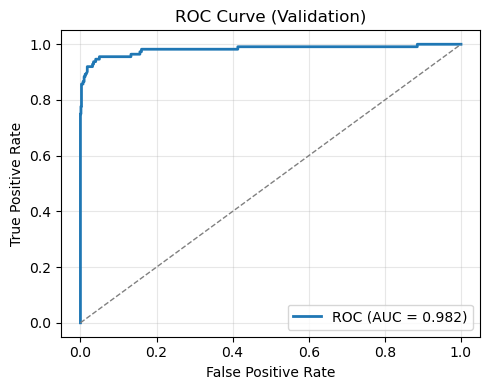

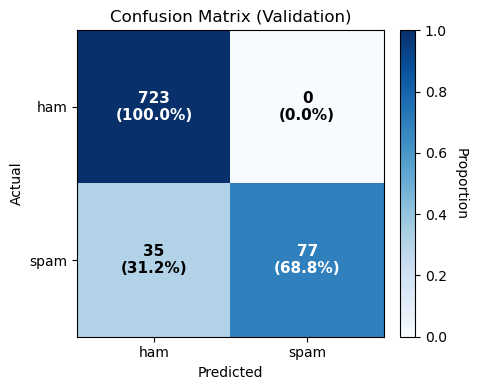

In [173]:
# Initialize model
nb_model = MultinomialNB()

# Fit model
nb_model = fit_model(nb_model, X_train, y_train)

# Score on train and validation
nb_train_scores = score_model(nb_model, X_train, y_train)
nb_val_scores = score_model(nb_model, X_val, y_val)

print("MultinomialNB - Train Scores:", nb_train_scores)
print("MultinomialNB - Validation Scores:", nb_val_scores)

# Detailed evaluation
evaluate_model(nb_model, X_train, y_train, split_name="Train")
evaluate_model(nb_model, X_val, y_val, split_name="Validation")

# Plots
plot_roc_and_confusion_matrix(nb_model,X_val,y_val,split_name="Validation")


### Benchmark Model 2: Logistic Regression

Logistic Regression is a linear classifier that performs well on
high-dimensional sparse text features such as TF-IDF.


Logistic Regression - Train Scores: {'accuracy': 0.9912820512820513, 'precision': 0.9519408502772643, 'recall': 0.9847036328871893, 'f1': 0.9680451127819549}
Logistic Regression - Validation Scores: {'accuracy': 0.98562874251497, 'precision': 0.9385964912280702, 'recall': 0.9553571428571429, 'f1': 0.9469026548672567}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      3377
        spam       0.95      0.98      0.97       523

    accuracy                           0.99      3900
   macro avg       0.97      0.99      0.98      3900
weighted avg       0.99      0.99      0.99      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       723
        spam       0.94      0.96      0.95       112

    accuracy                           0.99       835
   macro avg       0.97      0.97      0.97       835
weighted avg 

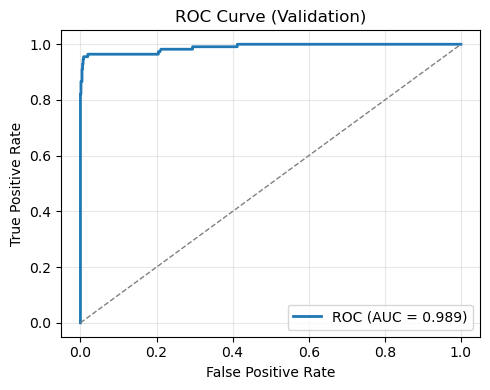

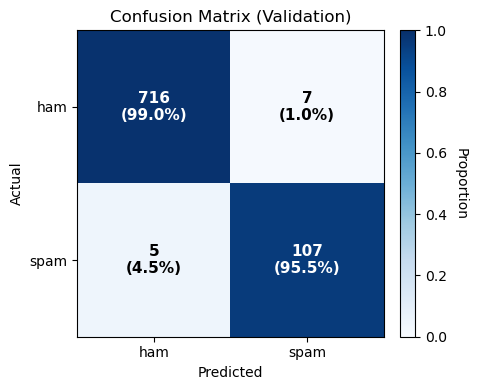

In [175]:
# Initialize model
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

# Fit model
lr_model = fit_model(lr_model, X_train, y_train)

# Score on train and validation
lr_train_scores = score_model(lr_model, X_train, y_train)
lr_val_scores = score_model(lr_model, X_val, y_val)

print("Logistic Regression - Train Scores:", lr_train_scores)
print("Logistic Regression - Validation Scores:", lr_val_scores)

# Detailed evaluation
evaluate_model(lr_model, X_train, y_train, split_name="Train")
evaluate_model(lr_model, X_val, y_val, split_name="Validation")

#Plots
plot_roc_and_confusion_matrix(lr_model,X_val,y_val,split_name="Validation")


### Benchmark Model 3: Linear Support Vector Classifier (LinearSVC)

LinearSVC is a linear margin-based classifier that is particularly effective
for high-dimensional sparse text representations such as TF-IDF.

LinearSVC - Train Scores: {'accuracy': 0.9992307692307693, 'precision': 0.9942965779467681, 'recall': 1.0, 'f1': 0.9971401334604385}
LinearSVC - Validation Scores: {'accuracy': 0.9868263473053892, 'precision': 0.9809523809523809, 'recall': 0.9196428571428571, 'f1': 0.9493087557603687}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3377
        spam       0.99      1.00      1.00       523

    accuracy                           1.00      3900
   macro avg       1.00      1.00      1.00      3900
weighted avg       1.00      1.00      1.00      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       723
        spam       0.98      0.92      0.95       112

    accuracy                           0.99       835
   macro avg       0.98      0.96      0.97       835
weighted avg       0.99      0.99      0.99   

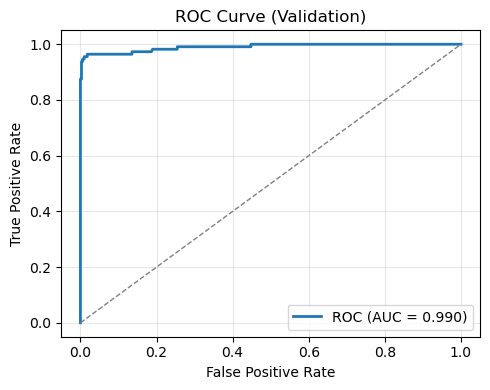

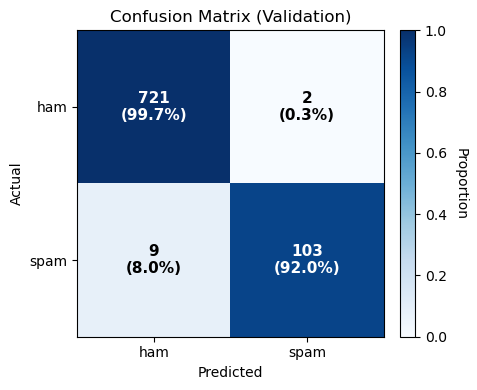

In [177]:
# Initialize model
svc_model = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42
)

# Fit model
svc_model = fit_model(svc_model, X_train, y_train)

# Score on train and validation
svc_train_scores = score_model(svc_model, X_train, y_train)
svc_val_scores = score_model(svc_model, X_val, y_val)

print("LinearSVC - Train Scores:", svc_train_scores)
print("LinearSVC - Validation Scores:", svc_val_scores)

# Detailed evaluation
evaluate_model(svc_model, X_train, y_train, split_name="Train")
evaluate_model(svc_model, X_val, y_val, split_name="Validation")

#Plots
plot_roc_and_confusion_matrix(svc_model,X_val,y_val,split_name="Validation")


### Benchmark Models: Train and Validation Performance

| Model               | Split       | Accuracy | Precision | Recall | F1-score |
|--------------------|------------|----------|-----------|--------|----------|
| **MultinomialNB**  | Train      | 0.976    | 1.000     | 0.822  | 0.902    |
|                    | Validation | 0.958    | 1.000     | 0.688  | 0.815    |
| **LogisticRegression** | Train  | 0.991    | 0.952     | 0.985  | 0.968    |
|                    | Validation | 0.986    | 0.939     | 0.955  | 0.947    |
| **LinearSVC**      | Train      | 0.999    | 0.994     | 1.000  | 0.997    |
|                    | Validation | 0.987    | 0.981     | 0.920  | 0.949    |


### 4. Hyperparameter Tuning

After establishing baseline performance on the training and validation sets,
we perform hyperparameter tuning to improve model generalization.
Hyperparameter tuning is carried out **only using the training and validation
sets**. The test set is kept completely unseen and is used once at the end
for final model comparison, ensuring no data leakage.

We tune a small, relevant set of hyperparameters for each benchmark model:

- **Multinomial Naive Bayes**: The smoothing parameter `alpha`, which controls
  the trade-off between reliance on observed word frequencies and robustness
  to rare words.

- **Logistic Regression**: The inverse regularization strength `C`, which
  controls the amount of L2 regularization applied to the model.

- **LinearSVC**: The regularization parameter `C`, which balances margin width
  and classification errors.

For each model, multiple values of the chosen hyperparameter are evaluated by
fitting on the training set and scoring on the validation set. The configuration
that achieves the best validation **F1-score** is selected, as F1-score is more
appropriate than accuracy for this imbalanced classification task.


In [179]:
# Define hyperparameter grid
nb_param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 5.0]}

# Initialize GridSearchCV
nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

# Fit on training data
nb_grid.fit(X_train, y_train)

# Best hyperparameter
print("Best alpha for MultinomialNB:", nb_grid.best_params_)

# Evaluate on train and validation
best_nb = nb_grid.best_estimator_
train_scores = score_model(best_nb, X_train, y_train)
val_scores = score_model(best_nb, X_val, y_val)

print("MultinomialNB - Train Scores:", train_scores)
print("MultinomialNB - Validation Scores:", val_scores)
# Detailed evaluation
evaluate_model(best_nb, X_train, y_train, split_name="Train")
evaluate_model(best_nb, X_val, y_val, split_name="Validation")


Best alpha for MultinomialNB: {'alpha': 0.1}
MultinomialNB - Train Scores: {'accuracy': 0.9961538461538462, 'precision': 1.0, 'recall': 0.97131931166348, 'f1': 0.98545101842871}
MultinomialNB - Validation Scores: {'accuracy': 0.9820359281437125, 'precision': 0.9801980198019802, 'recall': 0.8839285714285714, 'f1': 0.9295774647887324}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3377
        spam       1.00      0.97      0.99       523

    accuracy                           1.00      3900
   macro avg       1.00      0.99      0.99      3900
weighted avg       1.00      1.00      1.00      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       723
        spam       0.98      0.88      0.93       112

    accuracy                           0.98       835
   macro avg       0.98      0.94      0.96       8

In [183]:
# Define hyperparameter grid
lr_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    lr_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

# Fit on training data
lr_grid.fit(X_train, y_train)

# Best hyperparameter
print("Best C for LogisticRegression:", lr_grid.best_params_)

# Evaluate on train and validation
best_lr = lr_grid.best_estimator_
train_scores = score_model(best_lr, X_train, y_train)
val_scores = score_model(best_lr, X_val, y_val)

print("Logistic Regression - Train Scores:", train_scores)
print("Logistic Regression - Validation Scores:", val_scores)

# Detailed evaluation
evaluate_model(best_lr, X_train, y_train, split_name="Train")
evaluate_model(best_lr, X_val, y_val, split_name="Validation")



Best C for LogisticRegression: {'C': 100}
Logistic Regression - Train Scores: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Logistic Regression - Validation Scores: {'accuracy': 0.9868263473053892, 'precision': 0.9719626168224299, 'recall': 0.9285714285714286, 'f1': 0.9497716894977168}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3377
        spam       1.00      1.00      1.00       523

    accuracy                           1.00      3900
   macro avg       1.00      1.00      1.00      3900
weighted avg       1.00      1.00      1.00      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       723
        spam       0.97      0.93      0.95       112

    accuracy                           0.99       835
   macro avg       0.98      0.96      0.97       835
weighted avg       0.99      

In [185]:
# Define hyperparameter grid
svc_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV
svc_grid = GridSearchCV(
    LinearSVC(max_iter=5000, class_weight="balanced", random_state=42),
    svc_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

# Fit on training data
svc_grid.fit(X_train, y_train)

# Best hyperparameter
print("Best C for LinearSVC:", svc_grid.best_params_)

# Evaluate on train and validation
best_svc = svc_grid.best_estimator_
train_scores = score_model(best_svc, X_train, y_train)
val_scores = score_model(best_svc, X_val, y_val)

print("LinearSVC - Train Scores:", train_scores)
print("LinearSVC - Validation Scores:", val_scores)
# Detailed evaluation
evaluate_model(best_svc, X_train, y_train, split_name="Train")
evaluate_model(best_svc, X_val, y_val, split_name="Validation")



Best C for LinearSVC: {'C': 1}
LinearSVC - Train Scores: {'accuracy': 0.9992307692307693, 'precision': 0.9942965779467681, 'recall': 1.0, 'f1': 0.9971401334604385}
LinearSVC - Validation Scores: {'accuracy': 0.9868263473053892, 'precision': 0.9809523809523809, 'recall': 0.9196428571428571, 'f1': 0.9493087557603687}

Classification Report (Train):
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3377
        spam       0.99      1.00      1.00       523

    accuracy                           1.00      3900
   macro avg       1.00      1.00      1.00      3900
weighted avg       1.00      1.00      1.00      3900


Classification Report (Validation):
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       723
        spam       0.98      0.92      0.95       112

    accuracy                           0.99       835
   macro avg       0.98      0.96      0.97       835
weighted avg   

### Benchmark Models: Hyperparameter Tuning Results

| Model                | Best Hyperparameter | Train F1  | Validation F1 | Train Accuracy | Validation Accuracy |
|----------------------|------------------|-----------|---------------|----------------|-------------------|
| MultinomialNB        | alpha = 0.1      | 0.985     | 0.930         | 0.996          | 0.982             |
| Logistic Regression  | C = 100          | 1.000     | 0.950         | 1.000          | 0.987             |
| LinearSVC            | C = 1            | 0.997     | 0.949         | 0.999          | 0.987             |


### 5. Test Evaluation of Tuned Benchmark Models

After fitting and fine-tuning all three benchmark models on the training and validation data, we evaluate their performance on the **held-out test set**. This helps us select the final model for deployment.

**Models evaluated:**

- **MultinomialNB** - Naive Bayes classifier suitable for discrete text features (e.g., word counts, TF-IDF).  
- **Logistic Regression** - Linear classifier that performs well on high-dimensional sparse features.  
- **LinearSVC** - Linear Support Vector Classifier, robust to class imbalance and high-dimensional data.

**Evaluation Metrics:**

- **Accuracy** - Overall correctness of predictions.  
- **Precision** - Fraction of predicted positives that are truly positive.  
- **Recall** - Fraction of true positives correctly identified. Important for the minority spam class.  
- **F1-score** - Harmonic mean of precision and recall, balances the two.

MultinomialNB - Test Metrics
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       725
           1       0.96      0.89      0.93       112

    accuracy                           0.98       837
   macro avg       0.97      0.94      0.96       837
weighted avg       0.98      0.98      0.98       837





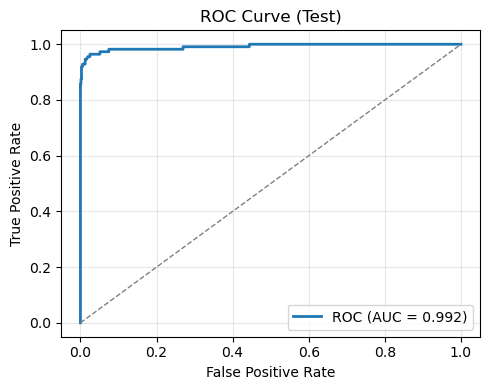

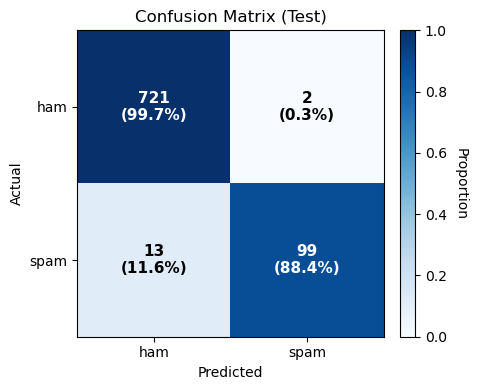

LogisticRegression - Test Metrics
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.94      0.92      0.93       112

    accuracy                           0.98       837
   macro avg       0.97      0.96      0.96       837
weighted avg       0.98      0.98      0.98       837





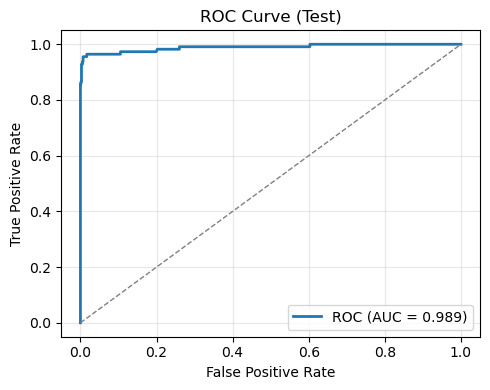

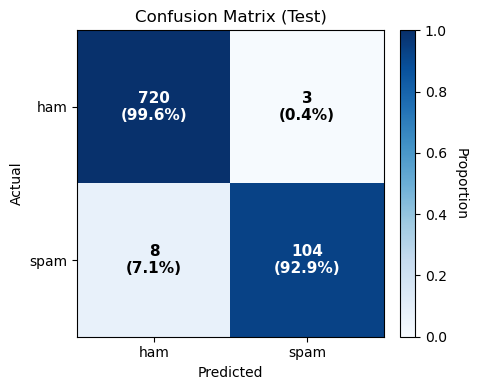

LinearSVC - Test Metrics
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.95      0.92      0.94       112

    accuracy                           0.98       837
   macro avg       0.97      0.96      0.96       837
weighted avg       0.98      0.98      0.98       837





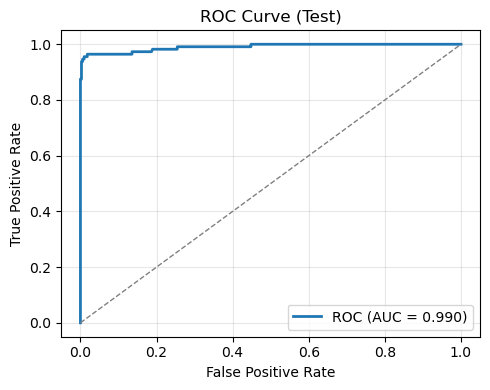

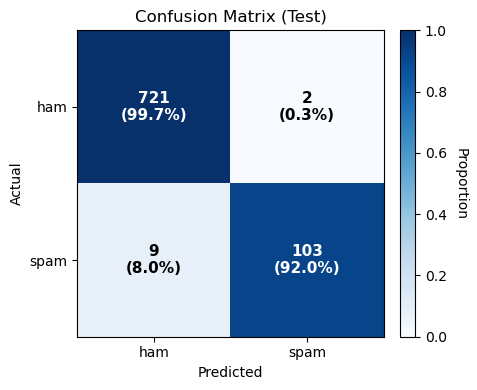

In [187]:
# Evaluate tuned models on test data
models = {
    "MultinomialNB": best_nb,
    "LogisticRegression": best_lr,
    "LinearSVC": best_svc
}

test_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    test_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    print(f"{name} - Test Metrics")
    print(classification_report(y_test, y_pred))
    print("\n")
    plot_roc_and_confusion_matrix(model,X_val,y_val,split_name="Test")
    



In [189]:
def select_best_model(results, metric="f1"):
    """
    Select best model based on a given metric.
    Default: spam-class F1.
    """
    return max(results.items(), key=lambda x: x[1][metric])


In [191]:
best_model_name, best_model_metrics = select_best_model(test_results)

print("Best model:", best_model_name)
print("Metrics:", best_model_metrics)


Best model: LinearSVC
Metrics: {'accuracy': 0.983273596176822, 'precision': 0.9537037037037037, 'recall': 0.9196428571428571, 'f1': 0.9363636363636364}


### Test Set Evaluation and Final Model Selection

| Model              | Accuracy | Precision (Macro) | Recall (Macro) | F1-Score (Macro) | F1-Score (Spam) |
|-------------------|----------|-------------------|----------------|------------------|-----------------|
| MultinomialNB      | 0.98     | 0.97              | 0.94           | 0.96             | 0.93            |
| LogisticRegression | 0.98     | 0.97              | 0.96           | 0.96             | 0.93            |
| LinearSVC          | 0.98     | 0.97              | 0.96           | 0.96             | 0.94            |

**Final Model Selection: LinearSVC**

**Reasons for choosing LinearSVC:**

1. **Better minority-class performance:** Achieves the highest spam F1-score while maintaining identical macro-averaged metrics compared to Logistic regression.
2. **Balanced performance across classes:** Macro precision, recall, and F1 indicate consistent behavior on both ham and spam classes.
3. **Well-suited for sparse, high-dimensional text features:** Performs robustly with TF-IDF representations.
4. **Better regularization behavior**: LinearSVC achieves comparable or better generalization under stronger regularization, whereas Logistic Regression requires weak regularization (C = 100), indicating a higher risk of overfitting in high-dimensional feature space.
   
**Conclusion:** Although all models show nearly identical macro-averaged performance, LinearSVC is selected due to its marginally superior spam-class F1-score. Logistic Regression remains almost equally competitive, while MultinomialNB serves as a strong and efficient baseline.
